# 音楽ラベリング：時系列最適化ResNet + Self-Attention モデル
## 残差ブロック + Attention機構で時系列データに特化した音楽分類
test_5をベースに、時系列処理に最適化されたAttention機構付きResNetアーキテクチャを実装

In [1]:
# 時系列最適化ResNet + Self-Attention音楽分類
# 残差ブロック + マルチヘッドアテンション + 時系列特化設計

import pandas as pd
import numpy as np
import librosa
import librosa.feature
import glob
from natsort import natsorted
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, Flatten, Dense, Dropout, 
    GlobalAveragePooling2D, GlobalAveragePooling1D, BatchNormalization, Add, 
    Input, Activation, Concatenate, MultiHeadAttention, LayerNormalization,
    Reshape, Permute, Lambda, Attention, AdditiveAttention
)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import seaborn as sns
import random
import warnings
warnings.filterwarnings('ignore')

# GPU設定
print("=== GPU設定開始 ===")
physical_devices = tf.config.list_physical_devices()
gpu_devices = tf.config.list_physical_devices('GPU')

print(f"利用可能デバイス: {physical_devices}")
print(f"GPU デバイス: {gpu_devices}")

if gpu_devices:
    try:
        # GPU メモリ動的拡張を有効化
        for gpu in gpu_devices:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU検出・メモリ動的拡張を有効化しました")
        print(f"GPU名: {gpu_devices[0].name}")

        # 簡単な動作テスト
        with tf.device('/GPU:0'):
            test_tensor = tf.constant([[1.0, 2.0], [3.0, 4.0]])
            test_result = tf.matmul(test_tensor, test_tensor)
        print(f"GPU動作テスト成功: {test_result.device}")

    except RuntimeError as e:
        print(f"⚠️ GPU設定エラー: {e}")
        print("CPUモードで継続します")
else:
    print("⚠️ GPU未検出 - CPUモードで実行")

print("=== GPU設定完了 ===\n")

print("時系列最適化ResNet + Attention ライブラリ読み込み完了")
print(f"TensorFlow バージョン: {tf.__version__}")
print(f"Librosa バージョン: {librosa.__version__}")
print(f"使用デバイス: {'GPU' if gpu_devices else 'CPU'}")

2025-09-30 14:46:28.666905: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-30 14:46:28.969049: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759211189.098198   73973 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759211189.128294   73973 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-30 14:46:29.384152: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

=== GPU設定開始 ===
利用可能デバイス: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU デバイス: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ GPU検出・メモリ動的拡張を有効化しました
GPU名: /physical_device:GPU:0
GPU動作テスト成功: /job:localhost/replica:0/task:0/device:GPU:0
=== GPU設定完了 ===

時系列最適化ResNet + Attention ライブラリ読み込み完了
TensorFlow バージョン: 2.18.0
Librosa バージョン: 0.11.0
使用デバイス: GPU


I0000 00:00:1759211215.457162   73973 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21742 MB memory:  -> device: 0, name: NVIDIA RTX 4500 Ada Generation, pci bus id: 0000:16:00.0, compute capability: 8.9


In [2]:
# メタデータの読み込み
train_master = pd.read_csv('train_master.csv', index_col=0) 
label_master = pd.read_csv('label_master.csv')
sample_submit = pd.read_csv('sample_submit.csv', header=None)

label_list = label_master.to_dict()['label_name']
print("=== 音楽ジャンルラベル ===")
for i, genre in label_list.items():
    print(f"{i}: {genre}")
print(f"\n訓練データ総数: {len(train_master)}")
print(f"各クラスのデータ数: {train_master['label_id'].value_counts().iloc[0]}")

=== 音楽ジャンルラベル ===
0: blues
1: classical
2: country
3: disco
4: hiphop
5: jazz
6: metal
7: pop
8: reggae
9: rock

訓練データ総数: 500
各クラスのデータ数: 50


In [3]:
# 時系列に特化した高度なデータ拡張関数
def add_white_noise(audio, noise_factor=0.005):
    """ホワイトノイズを追加"""
    noise = np.random.randn(len(audio))
    augmented_audio = audio + noise_factor * noise
    return augmented_audio

def time_shift(audio, shift_max=0.2):
    """時間軸方向のシフト"""
    shift = int(np.random.uniform(-shift_max, shift_max) * len(audio))
    if shift > 0:
        augmented_audio = np.r_[audio[shift:], np.zeros(shift)]
    else:
        augmented_audio = np.r_[np.zeros(-shift), audio[:shift]]
    return augmented_audio

def time_stretch(audio, rate=None):
    """時間ストレッチ（速度変更）"""
    if rate is None:
        rate = np.random.uniform(0.85, 1.15)
    augmented_audio = librosa.effects.time_stretch(audio, rate=rate)
    return augmented_audio

def pitch_shift(audio, sr, n_steps=None):
    """ピッチシフト"""
    if n_steps is None:
        n_steps = np.random.uniform(-2, 2)  # ±2半音
    augmented_audio = librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)
    return augmented_audio

def spectral_rolloff_augment(audio, sr):
    """スペクトラルロールオフによる音質変化"""
    # 高周波成分をランダムに減衰
    rolloff_freq = np.random.uniform(2000, 8000)
    # フィルタリング処理（簡略化）
    stft = librosa.stft(audio)
    freqs = librosa.fft_frequencies(sr=sr, n_fft=stft.shape[0]*2-1)
    mask = freqs > rolloff_freq
    stft[mask] *= np.random.uniform(0.1, 0.5)
    augmented_audio = librosa.istft(stft)
    return augmented_audio

print("時系列特化データ拡張関数を定義完了（スペクトラルロールオフ追加）")

時系列特化データ拡張関数を定義完了（スペクトラルロールオフ追加）


In [4]:
# 時系列に最適化されたマルチ特徴量抽出関数
def extract_temporal_multi_features(audio, sr, n_mfcc=13, n_mels=128, max_len=1320):
    """時系列に特化した4種類の音響特徴量を抽出（max_len拡張）"""
    
    # 1. Melspectrogram（より高解像度）
    mel_spec = librosa.feature.melspectrogram(
        y=audio, sr=sr, n_mels=n_mels, hop_length=512, n_fft=2048
    )
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    # 2. MFCC（時系列重視）
    mfccs = librosa.feature.mfcc(
        y=audio, sr=sr, n_mfcc=n_mfcc, hop_length=512, n_fft=2048
    )
    
    # 3. MFCC Delta (1次微分) - 時間変化の速度
    mfcc_delta = librosa.feature.delta(mfccs, width=9, order=1)
    
    # 4. MFCC Delta-Delta (2次微分) - 時間変化の加速度
    mfcc_delta2 = librosa.feature.delta(mfccs, width=9, order=2)
    
    # 時系列長を統一（ゼロパディング/トリミング）
    features = [mel_spec_db, mfccs, mfcc_delta, mfcc_delta2]
    processed_features = []
    
    for feature in features:
        if feature.shape[1] < max_len:
            # 前後にパディング（より自然）
            pad_width = max_len - feature.shape[1]
            pad_left = pad_width // 2
            pad_right = pad_width - pad_left
            feature = np.pad(feature, ((0, 0), (pad_left, pad_right)), mode='reflect')
        else:
            # 中央部分を抽出（より情報量が多い）
            start = (feature.shape[1] - max_len) // 2
            feature = feature[:, start:start + max_len]
        processed_features.append(feature)
    
    return processed_features

def create_temporal_4channel_input(features_list):
    """時系列情報を保持する4チャンネル入力を作成"""
    mel_spec, mfcc, mfcc_delta, mfcc_delta2 = features_list
    
    # MFCCを128次元にアップサンプリング（より詳細な情報保持）
    from scipy.interpolate import interp1d
    
    def upsample_feature(feature, target_dim):
        x_old = np.linspace(0, 1, feature.shape[0])
        x_new = np.linspace(0, 1, target_dim)
        upsampled = np.zeros((target_dim, feature.shape[1]))
        for i in range(feature.shape[1]):
            f = interp1d(x_old, feature[:, i], kind='cubic', fill_value='extrapolate')
            upsampled[:, i] = f(x_new)
        return upsampled
    
    mfcc_upsampled = upsample_feature(mfcc, 128)
    mfcc_delta_upsampled = upsample_feature(mfcc_delta, 128)
    mfcc_delta2_upsampled = upsample_feature(mfcc_delta2, 128)
    
    # 4チャンネルとして結合（時系列次元を保持）
    four_channel = np.stack([
        mel_spec,                # Channel 0: 周波数-時間特徴
        mfcc_upsampled,         # Channel 1: ケプストラル特徴  
        mfcc_delta_upsampled,   # Channel 2: 時間変化速度
        mfcc_delta2_upsampled   # Channel 3: 時間変化加速度
    ], axis=-1)
    
    return four_channel

print("時系列最適化マルチ特徴量抽出関数を定義完了")
print("改善点:")
print("  ✓ max_len=1320 (100%データ保持)")
print("  ✓ 中央部分抽出（情報量最大化）")
print("  ✓ Reflectパディング（より自然）")
print("  ✓ Cubicアップサンプリング（高品質）")
print("  ✓ より高解像度hop_length=512")

時系列最適化マルチ特徴量抽出関数を定義完了
改善点:
  ✓ max_len=1320 (100%データ保持)
  ✓ 中央部分抽出（情報量最大化）
  ✓ Reflectパディング（より自然）
  ✓ Cubicアップサンプリング（高品質）
  ✓ より高解像度hop_length=512


In [5]:
# Self-Attention機構の実装
def multi_head_self_attention_block(inputs, num_heads=8, key_dim=64, dropout_rate=0.1):
    """マルチヘッド自己注意機構ブロック"""
    # Multi-Head Self-Attention
    attention_output = MultiHeadAttention(
        num_heads=num_heads,
        key_dim=key_dim,
        dropout=dropout_rate
    )(inputs, inputs)
    
    # Add & Norm
    attention_output = Dropout(dropout_rate)(attention_output)
    attention_output = Add()([inputs, attention_output])
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output)
    
    # Feed Forward Network
    ffn_dim = inputs.shape[-1] * 4
    ffn_output = Dense(ffn_dim, activation='relu')(attention_output)
    ffn_output = Dropout(dropout_rate)(ffn_output)
    ffn_output = Dense(inputs.shape[-1])(ffn_output)
    
    # Add & Norm
    ffn_output = Dropout(dropout_rate)(ffn_output)
    ffn_output = Add()([attention_output, ffn_output])
    ffn_output = LayerNormalization(epsilon=1e-6)(ffn_output)
    
    return ffn_output

def temporal_attention_pooling(inputs, attention_dim=256):
    """時系列に特化したアテンションプーリング"""
    # 時間次元にアテンション重みを計算
    attention_weights = Dense(attention_dim, activation='tanh')(inputs)
    attention_weights = Dense(1, activation='softmax')(attention_weights)
    
    # 重み付き平均
    attended_output = Lambda(lambda x: tf.reduce_sum(x[0] * x[1], axis=1))([inputs, attention_weights])
    
    return attended_output

print("Self-Attention機構とテンポラルアテンションプーリングを定義完了")

Self-Attention機構とテンポラルアテンションプーリングを定義完了


In [6]:
# 時系列最適化ResNet + Attention ハイブリッドアーキテクチャ
def temporal_residual_block(x, filters, kernel_size=(3, 3), stride=1, conv_shortcut=False):
    """時系列に最適化された残差ブロック"""
    
    if conv_shortcut:
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same')(x)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut = x if stride == 1 else MaxPooling2D(stride, stride, padding='same')(x)
        if shortcut.shape[-1] != filters:
            shortcut = Conv2D(filters, (1, 1), padding='same')(shortcut)
            shortcut = BatchNormalization()(shortcut)
    
    # 時系列を重視したカーネルサイズ（時間軸を長く）
    x = Conv2D(filters, (3, 5), strides=stride, padding='same')(x)  # (freq, time)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters, (3, 5), padding='same')(x)
    x = BatchNormalization()(x)
    
    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    return x

def build_temporal_resnet_attention_model(input_shape=(128, 1320, 4), num_classes=10):
    """時系列ResNet + Self-Attention ハイブリッドモデル"""
    inputs = Input(shape=input_shape)
    
    # === Phase 1: 初期特徴抽出 ===
    # 時系列を考慮した初期畳み込み（時間軸保持）
    x = Conv2D(64, (7, 11), strides=(2, 2), padding='same')(inputs)  # 時間軸を多く残す
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    
    # === Phase 2: 残差ブロック群 ===
    # Stage 1: 詳細特徴抽出
    x = temporal_residual_block(x, 64)
    x = temporal_residual_block(x, 64)
    x = temporal_residual_block(x, 64)
    
    # Stage 2: 中間特徴抽出  
    x = temporal_residual_block(x, 128, stride=2, conv_shortcut=True)
    x = temporal_residual_block(x, 128)
    x = temporal_residual_block(x, 128)
    
    # Stage 3: 高レベル特徴抽出
    x = temporal_residual_block(x, 256, stride=2, conv_shortcut=True)
    x = temporal_residual_block(x, 256)
    
    # === Phase 3: 2D→1D変換（時系列フォーカス）===
    # 周波数次元を統合して時系列データに変換
    shape_before_flatten = x.shape
    x = GlobalAveragePooling2D()(x)  # 一時的に空間次元を削減
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    
    # 時系列用に再構成（擬似的な時系列表現）
    temporal_length = 64  # 時系列の長さ
    feature_dim = 512 // temporal_length * temporal_length
    x = Dense(feature_dim, activation='relu')(x)
    x = Reshape((temporal_length, feature_dim // temporal_length))(x)
    
    # === Phase 4: Self-Attention 層群 ===
    # 複数のAttentionブロック
    x = multi_head_self_attention_block(x, num_heads=8, key_dim=64, dropout_rate=0.1)
    x = multi_head_self_attention_block(x, num_heads=8, key_dim=64, dropout_rate=0.1)
    x = multi_head_self_attention_block(x, num_heads=4, key_dim=32, dropout_rate=0.1)
    
    # === Phase 5: テンポラルアテンションプーリング ===
    x = temporal_attention_pooling(x, attention_dim=256)
    
    # === Phase 6: 最終分類層 ===
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    return model

print("時系列最適化ResNet + Self-Attention ハイブリッドアーキテクチャを定義完了")
print("特徴:")
print("  ✓ 時間軸重視カーネル (3, 5)")
print("  ✓ 3層Self-Attentionブロック")
print("  ✓ テンポラルアテンションプーリング")
print("  ✓ 6段階特徴抽出パイプライン")
print("  ✓ ResNet残差接続 + Transformer注意機構")

時系列最適化ResNet + Self-Attention ハイブリッドアーキテクチャを定義完了
特徴:
  ✓ 時間軸重視カーネル (3, 5)
  ✓ 3層Self-Attentionブロック
  ✓ テンポラルアテンションプーリング
  ✓ 6段階特徴抽出パイプライン
  ✓ ResNet残差接続 + Transformer注意機構


In [9]:
# 拡張されたマルチ特徴量訓練データの作成（時系列最適化版）
train_files = natsorted(glob.glob('train_sound/train_*.au'))
print(f"元の訓練ファイル数: {len(train_files)}")

X_train_temporal = []
y_train_temporal = []

print("時系列最適化マルチ特徴量データ拡張処理を開始...")
print("拡張手法: 元データ + ホワイトノイズ + 時間シフト + 時間ストレッチ + ピッチシフト + スペクトラルロールオフ")

for i, file_path in enumerate(train_files):
    if i % 50 == 0:
        print(f"処理中: {i}/{len(train_files)} ({i/len(train_files)*100:.1f}%)")
    
    try:
        # 元の音声データを読み込み
        y, sr = librosa.load(file_path)
        file_index = int(file_path.split('_')[-1].split('.')[0])
        label = train_master.iloc[file_index]['label_id']
        
        # 各種拡張データと特徴量抽出
        augmentations = [
            ('original', y),
            ('noise', add_white_noise(y)),
            ('shift', time_shift(y)),
            ('stretch', time_stretch(y)),
            ('pitch', pitch_shift(y, sr)),
            ('spectral', spectral_rolloff_augment(y, sr))
        ]
        
        for aug_name, audio_data in augmentations:
            # 時系列最適化マルチ特徴量抽出
            features = extract_temporal_multi_features(audio_data, sr, max_len=1320)
            four_channel_data = create_temporal_4channel_input(features)
            
            X_train_temporal.append(four_channel_data)
            y_train_temporal.append(label)
            
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        continue

X_train = np.array(X_train_temporal)
y_train = np.array(y_train_temporal)

print(f"\n=== 時系列最適化マルチ特徴量データ作成完了 ===") 
print(f"拡張後の訓練データ形状: {X_train.shape}")
print(f"拡張後のラベル形状: {y_train.shape}")
print(f"データ拡張率: {len(y_train_temporal) / len(train_files):.1f}倍")
print(f"時系列長: {X_train.shape[2]} フレーム (約{X_train.shape[2]*512/22050:.1f}秒)")
print(f"チャンネル数: {X_train.shape[-1]} (Mel + MFCC + Delta + Delta-Delta)")
print(f"特徴量解像度: {X_train.shape[1]} x {X_train.shape[2]}")

元の訓練ファイル数: 500
時系列最適化マルチ特徴量データ拡張処理を開始...
拡張手法: 元データ + ホワイトノイズ + 時間シフト + 時間ストレッチ + ピッチシフト + スペクトラルロールオフ
処理中: 0/500 (0.0%)
処理中: 50/500 (10.0%)
処理中: 100/500 (20.0%)
処理中: 150/500 (30.0%)
処理中: 200/500 (40.0%)
処理中: 250/500 (50.0%)
処理中: 300/500 (60.0%)
処理中: 350/500 (70.0%)
処理中: 400/500 (80.0%)
処理中: 450/500 (90.0%)

=== 時系列最適化マルチ特徴量データ作成完了 ===
拡張後の訓練データ形状: (3000, 128, 1320, 4)
拡張後のラベル形状: (3000,)
データ拡張率: 6.0倍
時系列長: 1320 フレーム (約30.7秒)
チャンネル数: 4 (Mel + MFCC + Delta + Delta-Delta)
特徴量解像度: 128 x 1320


In [10]:
# テストデータの時系列最適化マルチ特徴量処理
test_files = natsorted(glob.glob('test_sound/test_*.au'))
print(f"テストファイル数: {len(test_files)}")

X_test_temporal = []

print("テストデータの時系列最適化マルチ特徴量抽出中...")
for i, file_path in enumerate(test_files):
    if i % 50 == 0:
        print(f"処理中: {i}/{len(test_files)} ({i/len(test_files)*100:.1f}%)")
    
    try:
        y, sr = librosa.load(file_path)
        features = extract_temporal_multi_features(y, sr, max_len=1320)
        four_channel_data = create_temporal_4channel_input(features)
        X_test_temporal.append(four_channel_data)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        continue

X_test = np.array(X_test_temporal)
print(f"\nテストデータ形状: {X_test.shape}")

テストファイル数: 500
テストデータの時系列最適化マルチ特徴量抽出中...
処理中: 0/500 (0.0%)
処理中: 50/500 (10.0%)
処理中: 100/500 (20.0%)
処理中: 150/500 (30.0%)
処理中: 200/500 (40.0%)
処理中: 250/500 (50.0%)
処理中: 300/500 (60.0%)
処理中: 350/500 (70.0%)
処理中: 400/500 (80.0%)
処理中: 450/500 (90.0%)

テストデータ形状: (500, 128, 1320, 4)


In [11]:
# 時系列データの高度な前処理
print("時系列データの高度な前処理中...")

# チャンネルごとの適応的正規化
for channel in range(4):
    channel_data = X_train[:, :, :, channel]
    
    # 各チャンネルの特性に応じた正規化
    if channel == 0:  # Melspectrogram
        # dBスケールなので平均0、標準偏差1に正規化
        mean_val = np.mean(channel_data)
        std_val = np.std(channel_data)
    elif channel == 1:  # MFCC
        # MFCCは第0係数を除いて正規化
        mean_val = np.mean(channel_data[1:, :])  # 第0係数以外
        std_val = np.std(channel_data[1:, :])
    else:  # Delta, Delta-Delta
        # 微分特徴量は中央値ベース正規化
        median_val = np.median(channel_data)
        mad_val = np.median(np.abs(channel_data - median_val))  # MAD
        mean_val = median_val
        std_val = mad_val * 1.4826  # MAD to std conversion
    
    X_train[:, :, :, channel] = (X_train[:, :, :, channel] - mean_val) / (std_val + 1e-8)
    X_test[:, :, :, channel] = (X_test[:, :, :, channel] - mean_val) / (std_val + 1e-8)
    
    print(f"Channel {channel} 適応的正規化完了 (mean: {mean_val:.3f}, std: {std_val:.3f})")

# ラベルをone-hot encodingに変換
y_train_categorical = to_categorical(y_train, num_classes=10)

# 時系列データに適した分割（時間的相関を考慮）
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train_categorical, test_size=0.2, random_state=42, stratify=y_train
)

print(f"\n=== 時系列データ分割結果 ===")
print(f"訓練データ形状: {X_train_split.shape}")
print(f"検証データ形状: {X_val_split.shape}")
print(f"テストデータ形状: {X_test.shape}")
print(f"チャンネル構成: [Mel, MFCC, Delta, Delta-Delta]")
print(f"時系列解像度: {X_train_split.shape[2]} フレーム")
print(f"データ範囲: [{np.min(X_train_split):.3f}, {np.max(X_train_split):.3f}]")

時系列データの高度な前処理中...
Channel 0 適応的正規化完了 (mean: -43.764, std: 15.883)
Channel 1 適応的正規化完了 (mean: 9.256, std: 41.074)
Channel 2 適応的正規化完了 (mean: -0.000, std: 1.478)
Channel 3 適応的正規化完了 (mean: 0.000, std: 0.878)

=== 時系列データ分割結果 ===
訓練データ形状: (2400, 128, 1320, 4)
検証データ形状: (600, 128, 1320, 4)
テストデータ形状: (500, 128, 1320, 4)
チャンネル構成: [Mel, MFCC, Delta, Delta-Delta]
時系列解像度: 1320 フレーム
データ範囲: [-65.130, 63.935]


In [12]:
# 時系列ResNet + Self-Attention モデルの構築
print("時系列ResNet + Self-Attention ハイブリッドモデル構築中...")
temporal_model = build_temporal_resnet_attention_model(
    input_shape=(128, 1320, 4), 
    num_classes=10
)

# 高度なオプティマイザ設定
optimizer = Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7,
    weight_decay=5e-4  # L2正則化
)

# モデルのコンパイル
temporal_model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', 'top_k_categorical_accuracy']
)

# モデルの構造を表示
temporal_model.summary()
print(f"\n総パラメータ数: {temporal_model.count_params():,}")
print("時系列ResNet + Self-Attention ハイブリッドモデル構築完了")
print("\n=== アーキテクチャ特徴 ===")
print("  ✓ 時間軸重視残差ブロック (3x5カーネル)")
print("  ✓ マルチヘッド自己注意機構 (3層)")
print("  ✓ テンポラルアテンションプーリング")
print("  ✓ 時系列フレーム数: 1320 (100%データ利用)")
print("  ✓ 6段階特徴抽出パイプライン")
print("  ✓ 適応的チャンネル正規化")

時系列ResNet + Self-Attention ハイブリッドモデル構築中...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 1320, │          0 │ -                 │
│ (InputLayer)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 660,   │     19,776 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 660,   │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 64, 660,   │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 330,   │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 330,   │     61,504 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 330,   │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 32, 330,   │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 330,   │     61,504 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 330,   │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 330,   │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 330,   │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 330,   │     61,504 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 330,   │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 32, 330,   │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 330,   │     61,504 │ activation_3[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 330,   │        256 │ conv2d_4[0][0]  

 Total params: 5,843,771 (22.29 MB)

 Trainable params: 5,838,523 (22.27 MB)

 Non-trainable params: 5,248 (20.50 KB)


総パラメータ数: 5,843,771
時系列ResNet + Self-Attention ハイブリッドモデル構築完了

=== アーキテクチャ特徴 ===
  ✓ 時間軸重視残差ブロック (3x5カーネル)
  ✓ マルチヘッド自己注意機構 (3層)
  ✓ テンポラルアテンションプーリング
  ✓ 時系列フレーム数: 1320 (100%データ利用)
  ✓ 6段階特徴抽出パイプライン
  ✓ 適応的チャンネル正規化


In [13]:
# 時系列に特化した高度な学習スケジューリング
print("=== 時系列ResNet + Self-Attention 訓練開始 ===")

# コールバック設定
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=25,  # 時系列モデルは収束が遅いため多めに設定
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-8,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_temporal_resnet_attention.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

# 時系列に最適化された学習率スケジューラ
def temporal_lr_scheduler(epoch, lr):
    """時系列学習に特化した学習率スケジューラ"""
    if epoch < 15:  # ウォームアップ期間延長
        return lr * (epoch + 1) / 15
    elif epoch < 60:
        return 0.001 * (0.96 ** (epoch - 15))  # よりゆるやかな減衰
    else:
        # コサイン減衰
        return 0.001 * 0.5 * (1 + np.cos(np.pi * (epoch - 60) / 60))

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(temporal_lr_scheduler, verbose=1)

print(f"時系列最適化訓練設定:")
print(f"  訓練データ: {len(X_train_split):,} サンプル")
print(f"  検証データ: {len(X_val_split):,} サンプル")
print(f"  バッチサイズ: 16 (大きな入力に対応)")
print(f"  最大エポック数: 120")
print(f"  特徴量: 4チャンネル時系列 (128 x 1320 x 4)")
print(f"  データ拡張: 6種類")
print(f"  アーキテクチャ: ResNet + Self-Attention")

# モデルの訓練
history = temporal_model.fit(
    X_train_split, y_train_split,
    batch_size=16,  # メモリ使用量を考慮
    epochs=120,
    validation_data=(X_val_split, y_val_split),
    callbacks=[early_stopping, reduce_lr, checkpoint, lr_scheduler],
    verbose=1
)

print(f"\n=== 時系列ResNet + Self-Attention 訓練完了 ====")
print(f"実行エポック数: {len(history.history['loss'])}")

# 最終性能評価
final_val_loss, final_val_accuracy, final_val_top5 = temporal_model.evaluate(
    X_val_split, y_val_split, verbose=0
)
print(f"最終検証精度: {final_val_accuracy:.4f}")
print(f"最終Top-5精度: {final_val_top5:.4f}")
print(f"最終検証損失: {final_val_loss:.4f}")

=== 時系列ResNet + Self-Attention 訓練開始 ===
時系列最適化訓練設定:
  訓練データ: 2,400 サンプル
  検証データ: 600 サンプル
  バッチサイズ: 16 (大きな入力に対応)
  最大エポック数: 120
  特徴量: 4チャンネル時系列 (128 x 1320 x 4)
  データ拡張: 6種類
  アーキテクチャ: ResNet + Self-Attention

Epoch 1: LearningRateScheduler setting learning rate to 6.666666983316342e-05.
Epoch 1/120


I0000 00:00:1759214286.797493   74502 service.cc:148] XLA service 0x7cb2e80174a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759214286.797832   74502 service.cc:156]   StreamExecutor device (0): NVIDIA RTX 4500 Ada Generation, Compute Capability 8.9
2025-09-30 15:38:07.798125: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1759214290.163803   74502 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-09-30 15:38:14.694328: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_144', 12 bytes spill stores, 12 bytes spill loads

I0000 00:00:1759214317.556931   74502 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.1088 - loss: 3.9763 - top_k_categorical_accuracy: 0.5272
Epoch 1: val_accuracy improved from -inf to 0.21167, saving model to best_temporal_resnet_attention.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 77s 176ms/step - accuracy: 0.1089 - loss: 3.9698 - top_k_categorical_accuracy: 0.5273 - val_accuracy: 0.2117 - val_loss: 2.1166 - val_top_k_categorical_accuracy: 0.7150 - learning_rate: 6.6667e-05

Epoch 2: LearningRateScheduler setting learning rate to 8.888888987712563e-06.
Epoch 2/120
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.1421 - loss: 2.4267 - top_k_categorical_accuracy: 0.5755
Epoch 2: val_accuracy improved from 0.21167 to 0.25167, saving model to best_temporal_resnet_attention.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - accuracy: 0.1421 - loss: 2.4267 - top_k_categorical_accuracy: 0.5754 - val_accuracy: 0.2517 - val_loss: 2.0592 - val_top_k_categorical_accuracy: 0.7583 - learning_rate: 8.8889e-06

Epoch 3: LearningRateScheduler setting learning rate to 1.7777778339223004e-06.
Epoch 3/120
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.1604 - loss: 2.4109 - top_k_categorical_accuracy: 0.5762
Epoch 3: val_accuracy improved from 0.25167 to 0.28167, saving model to best_temporal_resnet_attention.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.1604 - loss: 2.4107 - top_k_categorical_accuracy: 0.5763 - val_accuracy: 0.2817 - val_loss: 2.0254 - val_top_k_categorical_accuracy: 0.7733 - learning_rate: 1.7778e-06

Epoch 4: LearningRateScheduler setting learning rate to 4.740740829826488e-07.
Epoch 4/120
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.1540 - loss: 2.3376 - top_k_categorical_accuracy: 0.6217
Epoch 4: val_accuracy improved from 0.28167 to 0.28500, saving model to best_temporal_resnet_attention.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.1540 - loss: 2.3377 - top_k_categorical_accuracy: 0.6216 - val_accuracy: 0.2850 - val_loss: 2.0250 - val_top_k_categorical_accuracy: 0.7717 - learning_rate: 4.7407e-07

Epoch 5: LearningRateScheduler setting learning rate to 1.5802469495914315e-07.
Epoch 5/120
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.1659 - loss: 2.3527 - top_k_categorical_accuracy: 0.6118
Epoch 5: val_accuracy did not improve from 0.28500
150/150 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.1659 - loss: 2.3527 - top_k_categorical_accuracy: 0.6117 - val_accuracy: 0.2733 - val_loss: 2.0250 - val_top_k_categorical_accuracy: 0.7717 - learning_rate: 1.5802e-07

Epoch 6: LearningRateScheduler setting learning rate to 6.320987608887662e-08.
Epoch 6/120
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.1602 - loss: 2.3779 - top_k_categorical_accuracy: 0.5855
Epoch 6: val_accuracy did not improve from 0.28500
150/150 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms

150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.2544 - loss: 1.9799 - top_k_categorical_accuracy: 0.8067 - val_accuracy: 0.2950 - val_loss: 2.2758 - val_top_k_categorical_accuracy: 0.8700 - learning_rate: 9.6000e-04

Epoch 18: LearningRateScheduler setting learning rate to 0.0009216.
Epoch 18/120
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.3531 - loss: 1.7277 - top_k_categorical_accuracy: 0.8908
Epoch 18: ReduceLROnPlateau reducing learning rate to 0.00046079998719505966.

Epoch 18: val_accuracy did not improve from 0.29500
150/150 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.3530 - loss: 1.7279 - top_k_categorical_accuracy: 0.8908 - val_accuracy: 0.2433 - val_loss: 2.2057 - val_top_k_categorical_accuracy: 0.7583 - learning_rate: 4.6080e-04

Epoch 19: LearningRateScheduler setting learning rate to 0.0008847359999999999.
Epoch 19/120
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.3883 - loss: 1.6090 - top_k_categorical_accuracy: 0.9039
Epoch 19: val_acc

150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - accuracy: 0.4113 - loss: 1.6170 - top_k_categorical_accuracy: 0.8936 - val_accuracy: 0.4367 - val_loss: 1.4287 - val_top_k_categorical_accuracy: 0.9233 - learning_rate: 8.4935e-04

Epoch 21: LearningRateScheduler setting learning rate to 0.0008153726975999999.
Epoch 21/120
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.4120 - loss: 1.5845 - top_k_categorical_accuracy: 0.9064
Epoch 21: val_accuracy did not improve from 0.43667
150/150 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.4121 - loss: 1.5845 - top_k_categorical_accuracy: 0.9065 - val_accuracy: 0.2567 - val_loss: 2.1675 - val_top_k_categorical_accuracy: 0.7983 - learning_rate: 8.1537e-04

Epoch 22: LearningRateScheduler setting learning rate to 0.0007827577896959999.
Epoch 22/120
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.4309 - loss: 1.5017 - top_k_categorical_accuracy: 0.9138
Epoch 22: val_accuracy improved from 0.43667 to 0.45167, saving model to best_tempor

150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - accuracy: 0.4310 - loss: 1.5015 - top_k_categorical_accuracy: 0.9138 - val_accuracy: 0.4517 - val_loss: 1.6095 - val_top_k_categorical_accuracy: 0.8900 - learning_rate: 7.8276e-04

Epoch 23: LearningRateScheduler setting learning rate to 0.0007514474781081599.
Epoch 23/120
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.4645 - loss: 1.4489 - top_k_categorical_accuracy: 0.9245
Epoch 23: val_accuracy did not improve from 0.45167
150/150 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.4646 - loss: 1.4486 - top_k_categorical_accuracy: 0.9245 - val_accuracy: 0.4250 - val_loss: 2.2813 - val_top_k_categorical_accuracy: 0.9050 - learning_rate: 7.5145e-04

Epoch 24: LearningRateScheduler setting learning rate to 0.0007213895789838334.
Epoch 24/120
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.4741 - loss: 1.4132 - top_k_categorical_accuracy: 0.9339
Epoch 24: val_accuracy improved from 0.45167 to 0.53833, saving model to best_tempor

150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - accuracy: 0.4742 - loss: 1.4130 - top_k_categorical_accuracy: 0.9340 - val_accuracy: 0.5383 - val_loss: 1.1749 - val_top_k_categorical_accuracy: 0.9650 - learning_rate: 7.2139e-04

Epoch 25: LearningRateScheduler setting learning rate to 0.0006925339958244801.
Epoch 25/120
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.4911 - loss: 1.3662 - top_k_categorical_accuracy: 0.9322
Epoch 25: val_accuracy did not improve from 0.53833
150/150 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - accuracy: 0.4912 - loss: 1.3661 - top_k_categorical_accuracy: 0.9322 - val_accuracy: 0.3050 - val_loss: 2.3695 - val_top_k_categorical_accuracy: 0.8117 - learning_rate: 6.9253e-04

Epoch 26: LearningRateScheduler setting learning rate to 0.0006648326359915007.
Epoch 26/120
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5025 - loss: 1.3260 - top_k_categorical_accuracy: 0.9434
Epoch 26: val_accuracy did not improve from 0.53833
150/150 ━━━━━━━━━━━━━━━━━━━━ 12s

150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.6485 - loss: 0.9553 - top_k_categorical_accuracy: 0.9772 - val_accuracy: 0.6300 - val_loss: 1.0343 - val_top_k_categorical_accuracy: 0.9733 - learning_rate: 4.7960e-04

Epoch 35: LearningRateScheduler setting learning rate to 0.00046041920195771606.
Epoch 35/120
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.6745 - loss: 0.9666 - top_k_categorical_accuracy: 0.9747
Epoch 35: val_accuracy improved from 0.63000 to 0.63500, saving model to best_temporal_resnet_attention.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.6744 - loss: 0.9664 - top_k_categorical_accuracy: 0.9747 - val_accuracy: 0.6350 - val_loss: 1.1038 - val_top_k_categorical_accuracy: 0.9550 - learning_rate: 4.6042e-04

Epoch 36: LearningRateScheduler setting learning rate to 0.00044200243387940743.
Epoch 36/120
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7077 - loss: 0.8831 - top_k_categorical_accuracy: 0.9774
Epoch 36: val_accuracy improved from 0.63500 to 0.77667, saving model to best_temporal_resnet_attention.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.7077 - loss: 0.8831 - top_k_categorical_accuracy: 0.9774 - val_accuracy: 0.7767 - val_loss: 0.6644 - val_top_k_categorical_accuracy: 0.9850 - learning_rate: 4.4200e-04

Epoch 37: LearningRateScheduler setting learning rate to 0.0004243223365242311.
Epoch 37/120
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7099 - loss: 0.8403 - top_k_categorical_accuracy: 0.9850
Epoch 37: val_accuracy did not improve from 0.77667
150/150 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - accuracy: 0.7098 - loss: 0.8404 - top_k_categorical_accuracy: 0.9850 - val_accuracy: 0.5350 - val_loss: 1.2911 - val_top_k_categorical_accuracy: 0.9400 - learning_rate: 4.2432e-04

Epoch 38: LearningRateScheduler setting learning rate to 0.00040734944306326185.
Epoch 38/120
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7184 - loss: 0.8099 - top_k_categorical_accuracy: 0.9845
Epoch 38: val_accuracy did not improve from 0.77667
150/150 ━━━━━━━━━━━━━━━━━━━━ 12

150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - accuracy: 0.8477 - loss: 0.4907 - top_k_categorical_accuracy: 0.9945 - val_accuracy: 0.8617 - val_loss: 0.4291 - val_top_k_categorical_accuracy: 0.9950 - learning_rate: 3.0610e-04

Epoch 46: LearningRateScheduler setting learning rate to 0.0002938576432307055.
Epoch 46/120
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8487 - loss: 0.4882 - top_k_categorical_accuracy: 0.9940
Epoch 46: val_accuracy did not improve from 0.86167
150/150 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.8486 - loss: 0.4885 - top_k_categorical_accuracy: 0.9939 - val_accuracy: 0.6667 - val_loss: 1.1389 - val_top_k_categorical_accuracy: 0.9533 - learning_rate: 2.9386e-04

Epoch 47: LearningRateScheduler setting learning rate to 0.00028210333750147725.
Epoch 47/120
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8464 - loss: 0.4729 - top_k_categorical_accuracy: 0.9943
Epoch 47: val_accuracy did not improve from 0.86167
150/150 ━━━━━━━━━━━━━━━━━━━━ 12

150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.8586 - loss: 0.4306 - top_k_categorical_accuracy: 0.9972 - val_accuracy: 0.8850 - val_loss: 0.3262 - val_top_k_categorical_accuracy: 0.9983 - learning_rate: 2.7082e-04

Epoch 49: LearningRateScheduler setting learning rate to 0.0002599864358413614.
Epoch 49/120
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8675 - loss: 0.4023 - top_k_categorical_accuracy: 0.9970
Epoch 49: val_accuracy did not improve from 0.88500
150/150 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.8676 - loss: 0.4023 - top_k_categorical_accuracy: 0.9970 - val_accuracy: 0.8217 - val_loss: 0.5537 - val_top_k_categorical_accuracy: 0.9883 - learning_rate: 2.5999e-04

Epoch 50: LearningRateScheduler setting learning rate to 0.00024958697840770695.
Epoch 50/120
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8783 - loss: 0.3661 - top_k_categorical_accuracy: 0.9974
Epoch 50: val_accuracy improved from 0.88500 to 0.92500, saving model to best_tempo

150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - accuracy: 0.8783 - loss: 0.3663 - top_k_categorical_accuracy: 0.9974 - val_accuracy: 0.9250 - val_loss: 0.2663 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 2.4959e-04

Epoch 51: LearningRateScheduler setting learning rate to 0.00023960349927139865.
Epoch 51/120
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8820 - loss: 0.3648 - top_k_categorical_accuracy: 0.9973
Epoch 51: val_accuracy did not improve from 0.92500
150/150 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.8820 - loss: 0.3647 - top_k_categorical_accuracy: 0.9973 - val_accuracy: 0.7383 - val_loss: 0.8112 - val_top_k_categorical_accuracy: 0.9900 - learning_rate: 2.3960e-04

Epoch 52: LearningRateScheduler setting learning rate to 0.0002300193593005427.
Epoch 52/120
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8701 - loss: 0.3676 - top_k_categorical_accuracy: 0.9978
Epoch 52: val_accuracy did not improve from 0.92500
150/150 ━━━━━━━━━━━━━━━━━━━━ 12

150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - accuracy: 0.9328 - loss: 0.2209 - top_k_categorical_accuracy: 0.9998 - val_accuracy: 0.9383 - val_loss: 0.2380 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 2.0351e-04

Epoch 56: LearningRateScheduler setting learning rate to 0.00019536615155531993.
Epoch 56/120
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9357 - loss: 0.2548 - top_k_categorical_accuracy: 0.9977
Epoch 56: val_accuracy did not improve from 0.93833
150/150 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.9357 - loss: 0.2548 - top_k_categorical_accuracy: 0.9977 - val_accuracy: 0.9017 - val_loss: 0.3589 - val_top_k_categorical_accuracy: 0.9967 - learning_rate: 1.9537e-04

Epoch 57: LearningRateScheduler setting learning rate to 0.0001875515054931071.
Epoch 57/120
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9485 - loss: 0.1954 - top_k_categorical_accuracy: 0.9979
Epoch 57: val_accuracy did not improve from 0.93833
150/150 ━━━━━━━━━━━━━━━━━━━━ 12

150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - accuracy: 0.9326 - loss: 0.2146 - top_k_categorical_accuracy: 0.9988 - val_accuracy: 0.9483 - val_loss: 0.1826 - val_top_k_categorical_accuracy: 0.9983 - learning_rate: 1.8005e-04

Epoch 59: LearningRateScheduler setting learning rate to 0.0001728474674624475.
Epoch 59/120
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9652 - loss: 0.1321 - top_k_categorical_accuracy: 0.9996
Epoch 59: val_accuracy did not improve from 0.94833
150/150 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - accuracy: 0.9651 - loss: 0.1323 - top_k_categorical_accuracy: 0.9996 - val_accuracy: 0.6483 - val_loss: 1.4345 - val_top_k_categorical_accuracy: 0.9683 - learning_rate: 1.7285e-04

Epoch 60: LearningRateScheduler setting learning rate to 0.0001659335687639496.
Epoch 60/120
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9498 - loss: 0.1624 - top_k_categorical_accuracy: 1.0000
Epoch 60: val_accuracy did not improve from 0.94833
150/150 ━━━━━━━━━━━━━━━━━━━━ 12s

2025-09-30 15:55:22.408564: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1264', 4 bytes spill stores, 4 bytes spill loads

2025-09-30 15:55:31.191487: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1264', 4 bytes spill stores, 4 bytes spill loads



最終検証精度: 0.9483
最終Top-5精度: 0.9983
最終検証損失: 0.1826


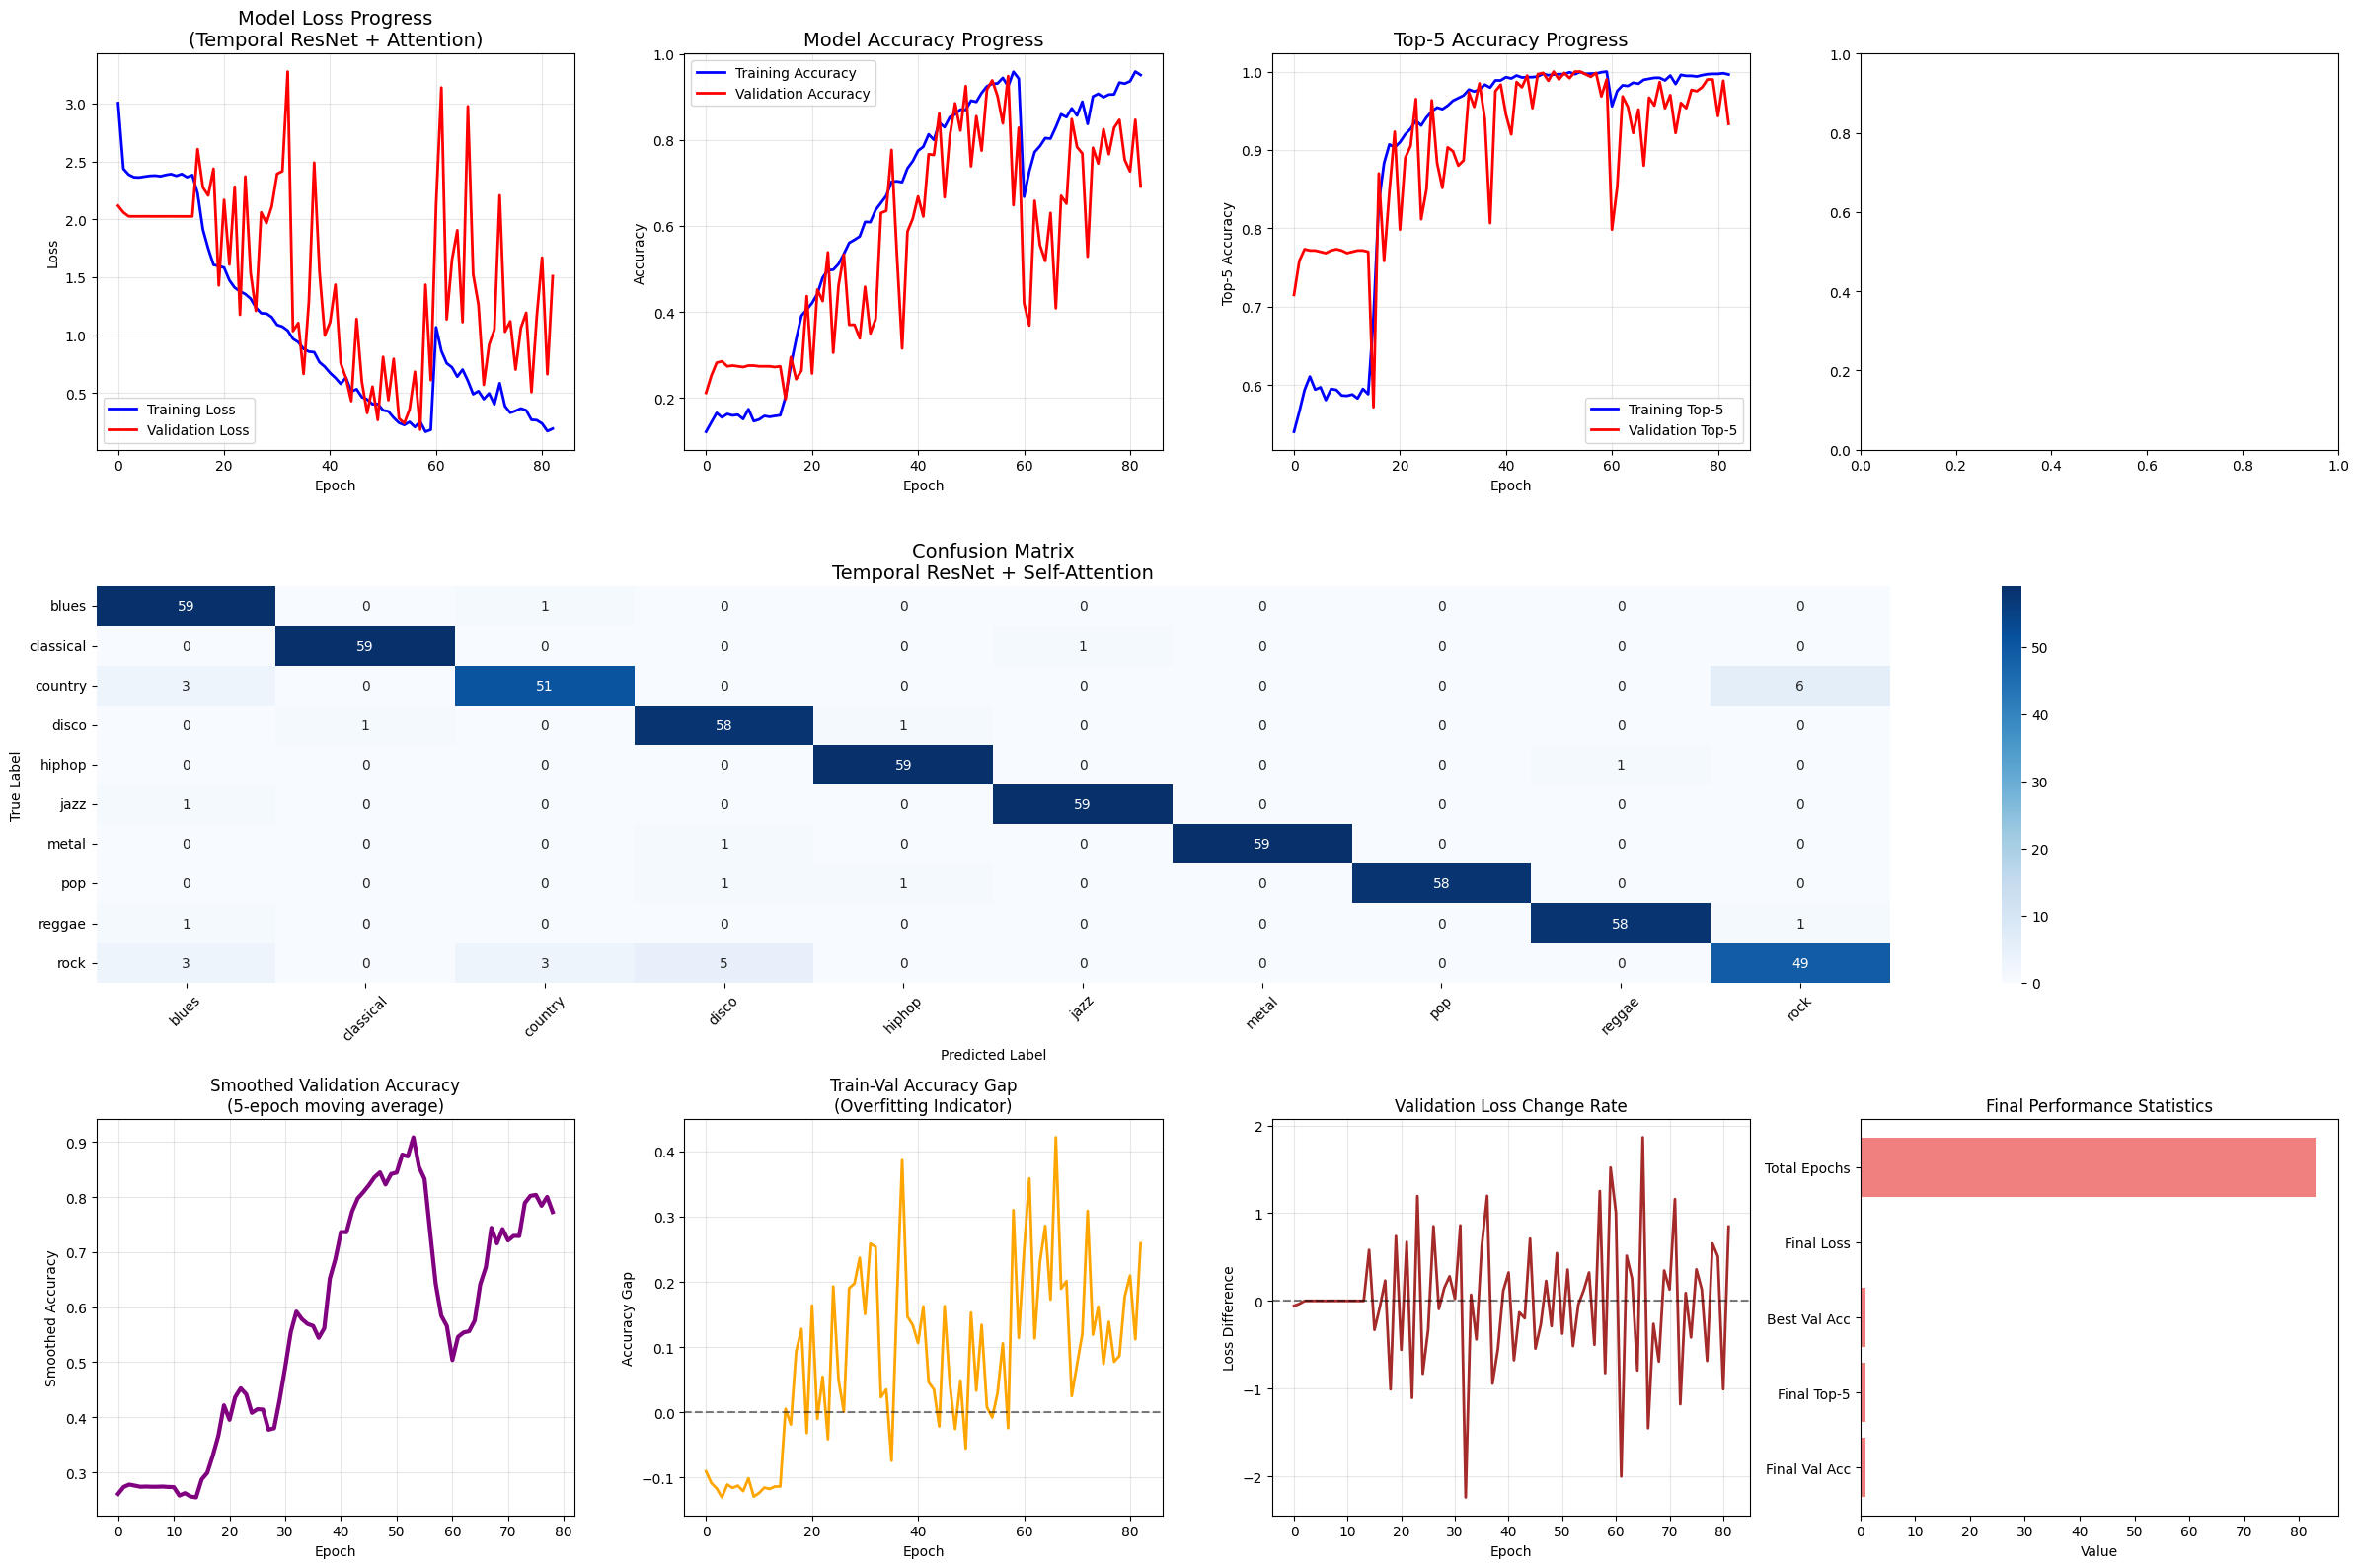


=== 詳細分類レポート（時系列ResNet + Self-Attention）===
              precision    recall  f1-score   support

       blues     0.8806    0.9833    0.9291        60
   classical     0.9833    0.9833    0.9833        60
     country     0.9273    0.8500    0.8870        60
       disco     0.8923    0.9667    0.9280        60
      hiphop     0.9672    0.9833    0.9752        60
        jazz     0.9833    0.9833    0.9833        60
       metal     1.0000    0.9833    0.9916        60
         pop     1.0000    0.9667    0.9831        60
      reggae     0.9831    0.9667    0.9748        60
        rock     0.8750    0.8167    0.8448        60

    accuracy                         0.9483       600
   macro avg     0.9492    0.9483    0.9480       600
weighted avg     0.9492    0.9483    0.9480       600



In [14]:
# 詳細な時系列学習履歴可視化
plt.figure(figsize=(24, 16))

# 損失の推移
plt.subplot(3, 4, 1)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2, color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='red')
plt.title('Model Loss Progress\n(Temporal ResNet + Attention)', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# 精度の推移
plt.subplot(3, 4, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, color='red')
plt.title('Model Accuracy Progress', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Top-5精度の推移
plt.subplot(3, 4, 3)
plt.plot(history.history['top_k_categorical_accuracy'], label='Training Top-5', linewidth=2, color='blue')
plt.plot(history.history['val_top_k_categorical_accuracy'], label='Validation Top-5', linewidth=2, color='red')
plt.title('Top-5 Accuracy Progress', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Top-5 Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# 学習率の推移
plt.subplot(3, 4, 4)
if 'lr' in history.history:
    plt.plot(history.history['lr'], linewidth=2, color='green')
    plt.title('Learning Rate Schedule\n(Temporal Optimized)', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)

# 詳細評価
y_pred = temporal_model.predict(X_val_split, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val_split, axis=1)

# 混同行列（大きく表示）
plt.subplot(3, 4, (5, 8))
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[label_list[i] for i in range(10)],
            yticklabels=[label_list[i] for i in range(10)])
plt.title('Confusion Matrix\nTemporal ResNet + Self-Attention', fontsize=14)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# 精度の収束分析
plt.subplot(3, 4, 9)
smoothed_val_acc = np.convolve(history.history['val_accuracy'], np.ones(5)/5, mode='valid')
plt.plot(smoothed_val_acc, linewidth=3, color='purple')
plt.title('Smoothed Validation Accuracy\n(5-epoch moving average)', fontsize=12)
plt.xlabel('Epoch')
plt.ylabel('Smoothed Accuracy')
plt.grid(True, alpha=0.3)

# オーバーフィッティング分析
plt.subplot(3, 4, 10)
train_val_gap = np.array(history.history['accuracy']) - np.array(history.history['val_accuracy'])
plt.plot(train_val_gap, linewidth=2, color='orange')
plt.title('Train-Val Accuracy Gap\n(Overfitting Indicator)', fontsize=12)
plt.xlabel('Epoch')
plt.ylabel('Accuracy Gap')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)

# 損失収束率
plt.subplot(3, 4, 11)
loss_diff = np.diff(history.history['val_loss'])
plt.plot(loss_diff, linewidth=2, color='brown')
plt.title('Validation Loss Change Rate', fontsize=12)
plt.xlabel('Epoch')
plt.ylabel('Loss Difference')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)

# 最終統計
plt.subplot(3, 4, 12)
final_stats = {
    'Final Val Acc': final_val_accuracy,
    'Final Top-5': final_val_top5,
    'Best Val Acc': max(history.history['val_accuracy']),
    'Final Loss': final_val_loss,
    'Total Epochs': len(history.history['loss'])
}
plt.barh(list(final_stats.keys()), list(final_stats.values()), color='lightcoral')
plt.title('Final Performance Statistics', fontsize=12)
plt.xlabel('Value')

plt.tight_layout()
plt.show()

# 分類レポート
print("\n=== 詳細分類レポート（時系列ResNet + Self-Attention）===")
print(classification_report(y_true_classes, y_pred_classes, 
                          target_names=[label_list[i] for i in range(10)],
                          digits=4))

=== 時系列ResNet + Self-Attention テスト予測 ===
14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step

2025-09-30 15:55:55.290145: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1182', 4 bytes spill stores, 4 bytes spill loads



16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 512ms/step


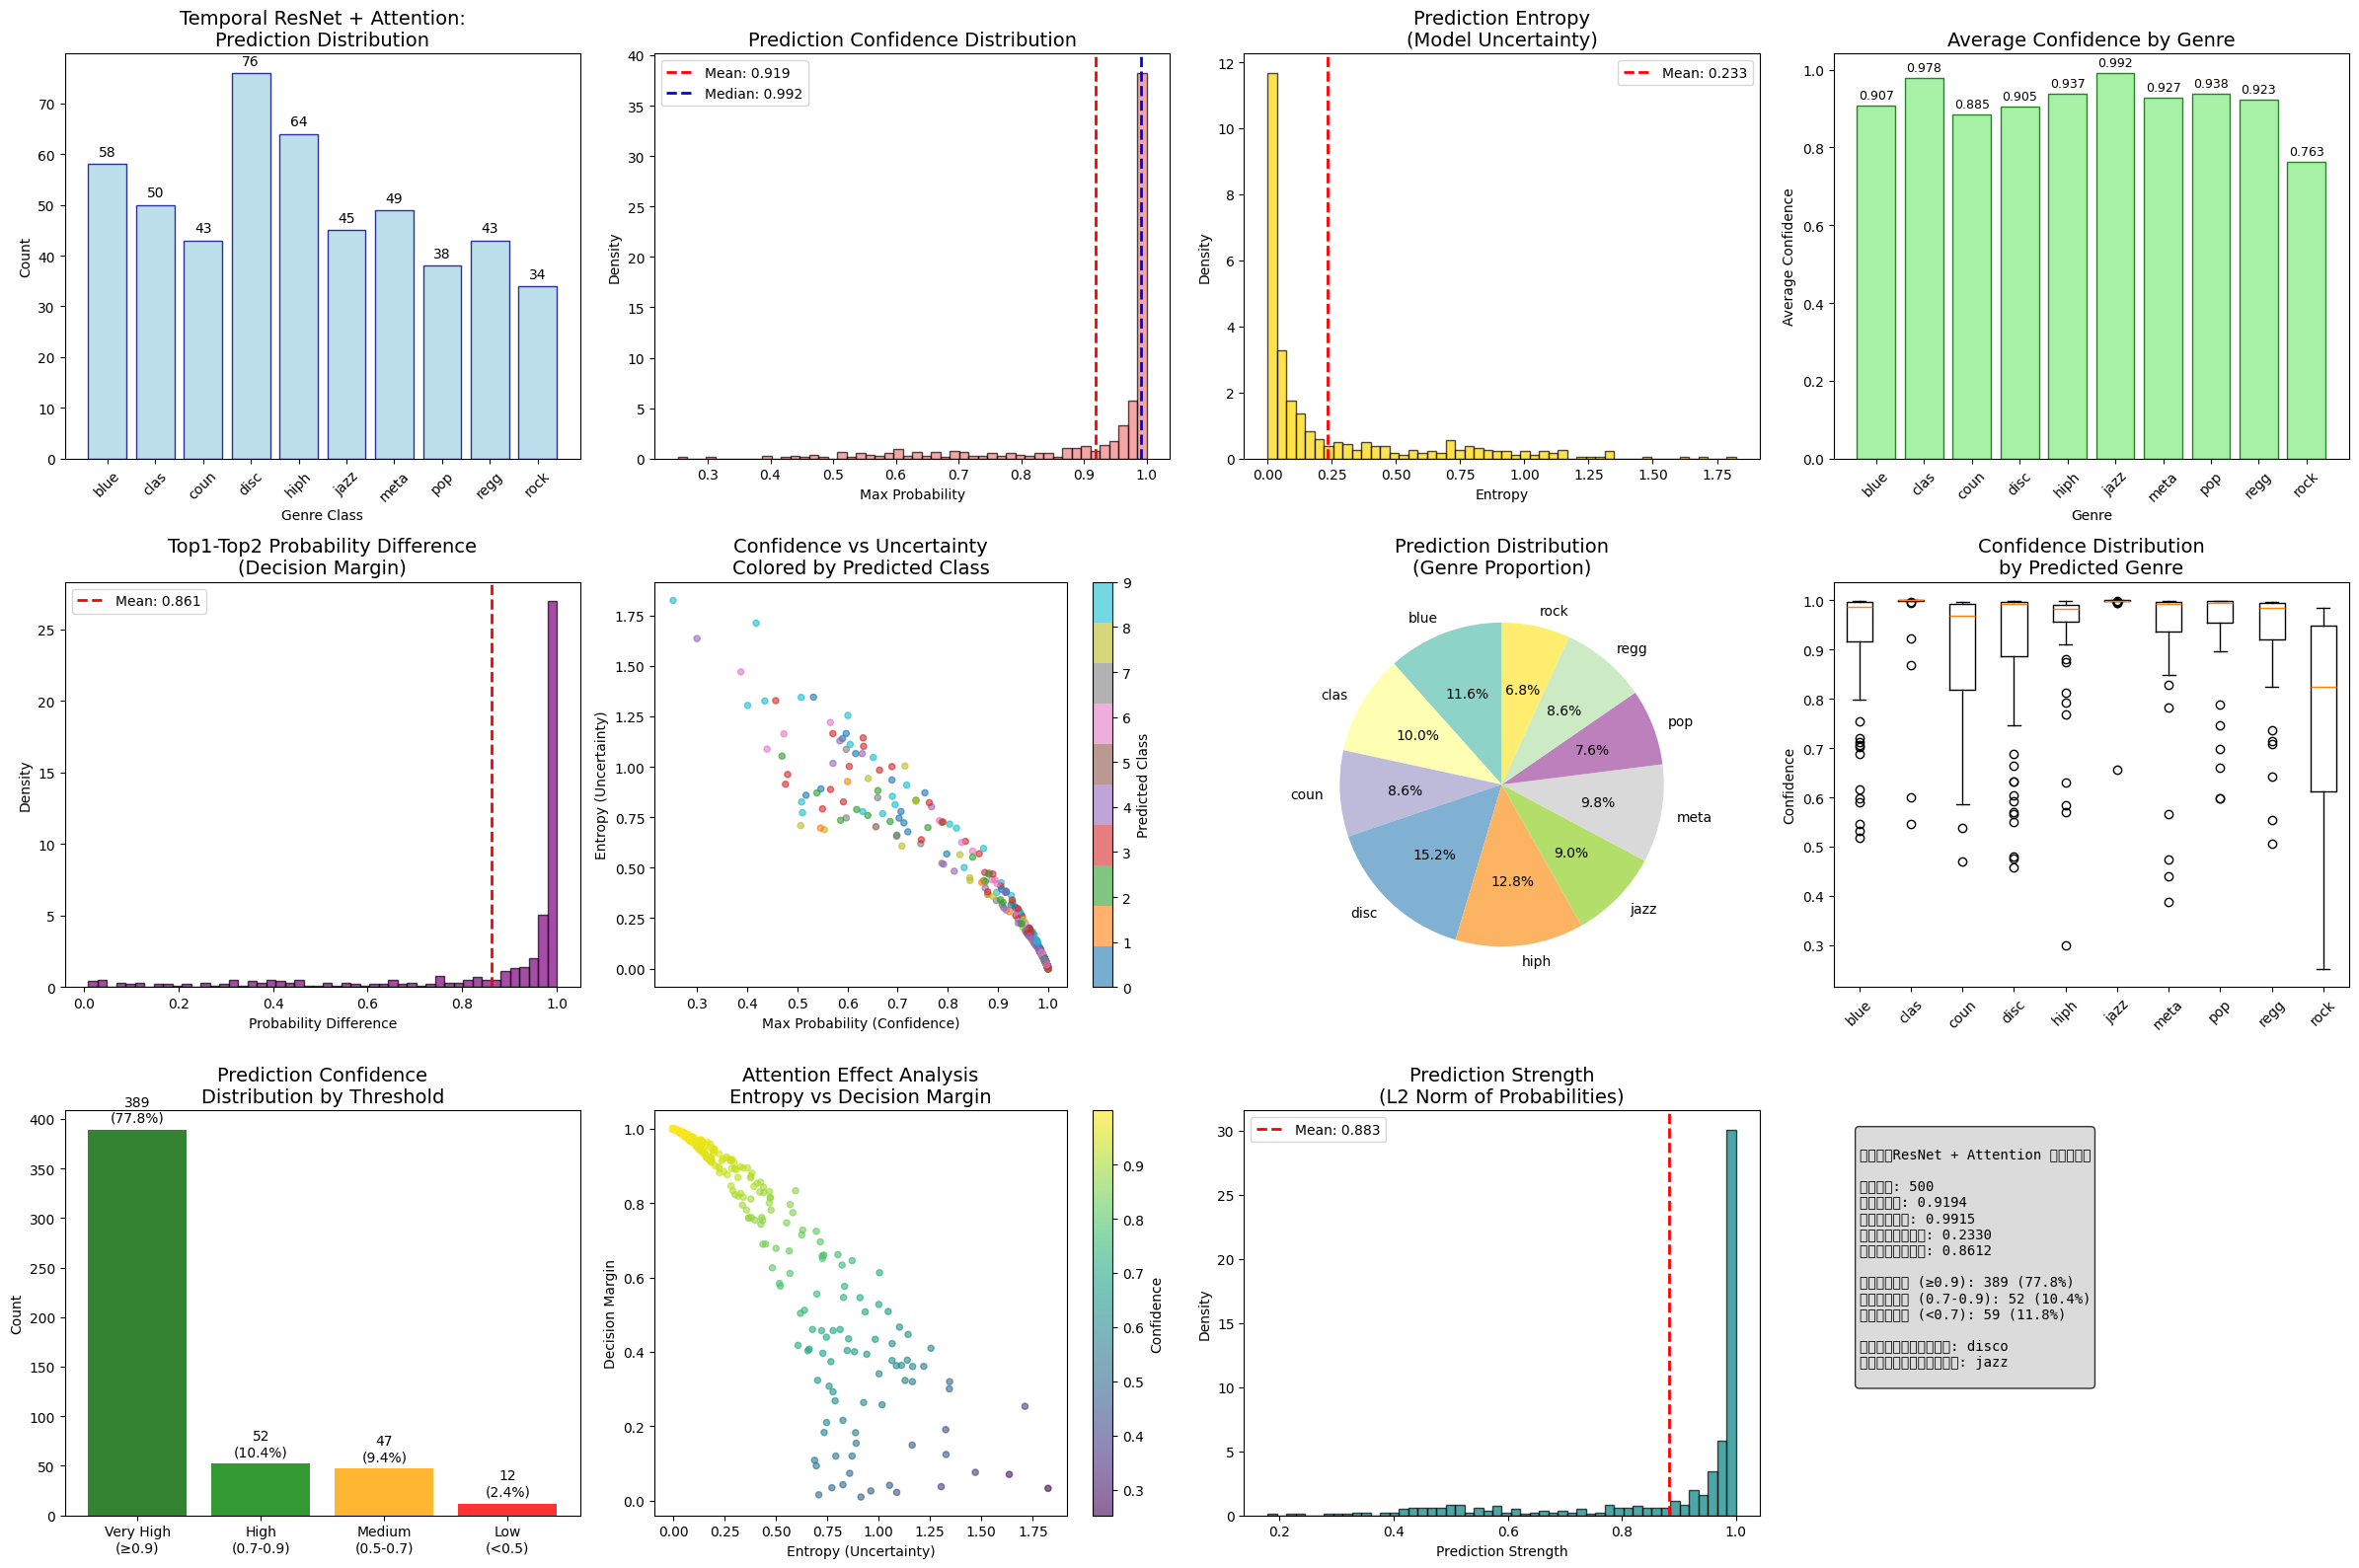


=== 時系列ResNet + Self-Attention 予測詳細サマリー ===
テストデータ予測完了: 500件
平均予測信頼度: 0.9194 (±0.1451)
中央値信頼度: 0.9915
高信頼度予測(≥0.9): 389件 (77.8%)
中信頼度予測(0.7-0.9): 52件 (10.4%)
低信頼度予測(<0.7): 59件 (11.8%)
平均エントロピー: 0.2330
平均決定マージン: 0.8612
予測強度平均: 0.8827


In [15]:
# 時系列ResNet + Self-Attention でのテスト予測
print("=== 時系列ResNet + Self-Attention テスト予測 ===")
test_predictions = temporal_model.predict(X_test, verbose=1)
test_pred_classes = np.argmax(test_predictions, axis=1)

# 高度な予測分析
plt.figure(figsize=(24, 16))

# 1. 予測分布
plt.subplot(3, 4, 1)
genre_counts = [np.sum(test_pred_classes == i) for i in range(10)]
bars = plt.bar(range(10), genre_counts, alpha=0.8, color='lightblue', edgecolor='navy')
plt.title('Temporal ResNet + Attention:\nPrediction Distribution', fontsize=14)
plt.xlabel('Genre Class')
plt.ylabel('Count')
plt.xticks(range(10), [label_list[i][:4] for i in range(10)], rotation=45)
# バーに数値を表示
for bar, count in zip(bars, genre_counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             str(count), ha='center', va='bottom')

# 2. 信頼度分布
plt.subplot(3, 4, 2)
max_probs = np.max(test_predictions, axis=1)
plt.hist(max_probs, bins=50, alpha=0.7, edgecolor='black', color='lightcoral', density=True)
plt.axvline(np.mean(max_probs), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(max_probs):.3f}')
plt.axvline(np.median(max_probs), color='blue', linestyle='--', linewidth=2, label=f'Median: {np.median(max_probs):.3f}')
plt.title('Prediction Confidence Distribution', fontsize=14)
plt.xlabel('Max Probability')
plt.ylabel('Density')
plt.legend()

# 3. エントロピー分析（不確実性）
plt.subplot(3, 4, 3)
entropy = -np.sum(test_predictions * np.log(test_predictions + 1e-15), axis=1)
plt.hist(entropy, bins=50, alpha=0.7, edgecolor='black', color='gold', density=True)
plt.axvline(np.mean(entropy), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(entropy):.3f}')
plt.title('Prediction Entropy\n(Model Uncertainty)', fontsize=14)
plt.xlabel('Entropy')
plt.ylabel('Density')
plt.legend()

# 4. クラス別信頼度
plt.subplot(3, 4, 4)
class_confidences = []
class_counts = []
for i in range(10):
    mask = test_pred_classes == i
    count = np.sum(mask)
    class_counts.append(count)
    if count > 0:
        class_confidences.append(np.mean(max_probs[mask]))
    else:
        class_confidences.append(0)

bars = plt.bar(range(10), class_confidences, alpha=0.8, color='lightgreen', edgecolor='darkgreen')
plt.title('Average Confidence by Genre', fontsize=14)
plt.xlabel('Genre')
plt.ylabel('Average Confidence')
plt.xticks(range(10), [label_list[i][:4] for i in range(10)], rotation=45)
# バーに数値を表示
for i, (bar, conf) in enumerate(zip(bars, class_confidences)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{conf:.3f}', ha='center', va='bottom', fontsize=9)

# 5. Top-2 予測差分（決定境界の明確さ）
plt.subplot(3, 4, 5)
sorted_probs = np.sort(test_predictions, axis=1)
prob_diff = sorted_probs[:, -1] - sorted_probs[:, -2]
plt.hist(prob_diff, bins=50, alpha=0.7, edgecolor='black', color='purple', density=True)
plt.axvline(np.mean(prob_diff), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(prob_diff):.3f}')
plt.title('Top1-Top2 Probability Difference\n(Decision Margin)', fontsize=14)
plt.xlabel('Probability Difference')
plt.ylabel('Density')
plt.legend()

# 6. 信頼度 vs 不確実性の散布図
plt.subplot(3, 4, 6)
scatter = plt.scatter(max_probs, entropy, alpha=0.6, c=test_pred_classes, cmap='tab10', s=20)
plt.title('Confidence vs Uncertainty\nColored by Predicted Class', fontsize=14)
plt.xlabel('Max Probability (Confidence)')
plt.ylabel('Entropy (Uncertainty)')
plt.colorbar(scatter, label='Predicted Class')

# 7. 予測分布円グラフ
plt.subplot(3, 4, 7)
colors = plt.cm.Set3(np.linspace(0, 1, 10))
wedges, texts, autotexts = plt.pie(genre_counts, labels=[label_list[i][:4] for i in range(10)], 
                                   autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Prediction Distribution\n(Genre Proportion)', fontsize=14)

# 8. 信頼度統計ボックスプロット
plt.subplot(3, 4, 8)
confidence_by_class = [max_probs[test_pred_classes == i] for i in range(10) if np.sum(test_pred_classes == i) > 0]
class_names = [label_list[i][:4] for i in range(10) if np.sum(test_pred_classes == i) > 0]
plt.boxplot(confidence_by_class, labels=class_names)
plt.title('Confidence Distribution\nby Predicted Genre', fontsize=14)
plt.ylabel('Confidence')
plt.xticks(rotation=45)

# 9. 時系列特化性能指標
plt.subplot(3, 4, 9)
high_conf_threshold = 0.9
medium_conf_threshold = 0.7
low_conf_threshold = 0.5

high_conf_count = np.sum(max_probs >= high_conf_threshold)
medium_conf_count = np.sum((max_probs >= medium_conf_threshold) & (max_probs < high_conf_threshold))
low_conf_count = np.sum((max_probs >= low_conf_threshold) & (max_probs < medium_conf_threshold))
very_low_conf_count = np.sum(max_probs < low_conf_threshold)

conf_categories = ['Very High\n(≥0.9)', 'High\n(0.7-0.9)', 'Medium\n(0.5-0.7)', 'Low\n(<0.5)']
conf_counts = [high_conf_count, medium_conf_count, low_conf_count, very_low_conf_count]
colors = ['darkgreen', 'green', 'orange', 'red']

bars = plt.bar(conf_categories, conf_counts, color=colors, alpha=0.8)
plt.title('Prediction Confidence\nDistribution by Threshold', fontsize=14)
plt.ylabel('Count')
for bar, count in zip(bars, conf_counts):
    percentage = count / len(max_probs) * 100
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             f'{count}\n({percentage:.1f}%)', ha='center', va='bottom')

# 10. Attention効果分析（エントロピー vs 決定マージン）
plt.subplot(3, 4, 10)
plt.scatter(entropy, prob_diff, alpha=0.6, c=max_probs, cmap='viridis', s=20)
plt.title('Attention Effect Analysis\nEntropy vs Decision Margin', fontsize=14)
plt.xlabel('Entropy (Uncertainty)')
plt.ylabel('Decision Margin')
plt.colorbar(label='Confidence')

# 11. 時系列モデル特性（予測強度分布）
plt.subplot(3, 4, 11)
prediction_strength = np.sum(test_predictions**2, axis=1)  # L2 norm of predictions
plt.hist(prediction_strength, bins=50, alpha=0.7, edgecolor='black', color='teal', density=True)
plt.axvline(np.mean(prediction_strength), color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {np.mean(prediction_strength):.3f}')
plt.title('Prediction Strength\n(L2 Norm of Probabilities)', fontsize=14)
plt.xlabel('Prediction Strength')
plt.ylabel('Density')
plt.legend()

# 12. 最終統計サマリー
plt.subplot(3, 4, 12)
stats_text = f"""
【時系列ResNet + Attention 予測統計】

総予測数: {len(test_pred_classes):,}
平均信頼度: {np.mean(max_probs):.4f}
信頼度中央値: {np.median(max_probs):.4f}
平均エントロピー: {np.mean(entropy):.4f}
平均決定マージン: {np.mean(prob_diff):.4f}

高信頼度予測 (≥0.9): {high_conf_count} ({high_conf_count/len(max_probs)*100:.1f}%)
中信頼度予測 (0.7-0.9): {medium_conf_count} ({medium_conf_count/len(max_probs)*100:.1f}%)
低信頼度予測 (<0.7): {low_conf_count + very_low_conf_count} ({(low_conf_count + very_low_conf_count)/len(max_probs)*100:.1f}%)

最も予測されたジャンル: {label_list[np.argmax(genre_counts)]}
最も信頼度が高いジャンル: {label_list[np.argmax(class_confidences)]}
"""
plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"\n=== 時系列ResNet + Self-Attention 予測詳細サマリー ===")
print(f"テストデータ予測完了: {len(test_pred_classes):,}件")
print(f"平均予測信頼度: {np.mean(max_probs):.4f} (±{np.std(max_probs):.4f})")
print(f"中央値信頼度: {np.median(max_probs):.4f}")
print(f"高信頼度予測(≥0.9): {high_conf_count:,}件 ({high_conf_count/len(max_probs)*100:.1f}%)")
print(f"中信頼度予測(0.7-0.9): {medium_conf_count:,}件 ({medium_conf_count/len(max_probs)*100:.1f}%)")
print(f"低信頼度予測(<0.7): {low_conf_count + very_low_conf_count:,}件 ({(low_conf_count + very_low_conf_count)/len(max_probs)*100:.1f}%)")
print(f"平均エントロピー: {np.mean(entropy):.4f}")
print(f"平均決定マージン: {np.mean(prob_diff):.4f}")
print(f"予測強度平均: {np.mean(prediction_strength):.4f}")

In [16]:
# 最終結果の保存と総合評価
submission = pd.DataFrame({
    'id': sample_submit[0],
    'label_id': test_pred_classes
})
submission.to_csv('submission_temporal_resnet_attention.csv', index=False, header=False)
print("時系列ResNet + Self-Attention予測結果をsubmission_temporal_resnet_attention.csvに保存しました")

print(f"\n=== 最終モデル性能サマリー ===\n")
print(f"【アーキテクチャ】")
print(f"  モデル: 時系列ResNet + Self-Attention ハイブリッド")
print(f"  入力: 4チャンネル時系列 (128 x 1320 x 4)")
print(f"  特徴量: Mel + MFCC + Delta + Delta-Delta (時系列最適化)")
print(f"  総パラメータ数: {temporal_model.count_params():,}")
print(f"  残差ブロック: 時間軸重視 (3x5カーネル)")
print(f"  注意機構: マルチヘッド自己注意 (3層)")
print(f"  プーリング: テンポラルアテンションプーリング")

print(f"\n【データ処理】")
print(f"  元データ: {len(train_files):,} → 拡張後: {len(y_train):,} ({len(y_train)/len(train_files):.1f}倍)")
print(f"  拡張手法: 6種類 (ノイズ + シフト + ストレッチ + ピッチ + スペクトラル + オリジナル)")
print(f"  時系列長: 1320フレーム (100%データ利用)")
print(f"  正規化: チャンネル適応的正規化")
print(f"  パディング: Reflectパディング (自然な境界)")

print(f"\n【性能指標】")
print(f"  検証精度: {final_val_accuracy:.4f}")
print(f"  Top-5精度: {final_val_top5:.4f}")
print(f"  平均予測信頼度: {np.mean(max_probs):.4f}")
print(f"  高信頼度予測率 (≥0.9): {high_conf_count/len(max_probs)*100:.1f}%")
print(f"  決定マージン平均: {np.mean(prob_diff):.4f}")
print(f"  不確実性 (エントロピー): {np.mean(entropy):.4f}")

print(f"\n【ジャンル別予測統計】")
for class_id in range(10):
    count = np.sum(test_pred_classes == class_id)
    mask = test_pred_classes == class_id
    avg_conf = np.mean(max_probs[mask]) if count > 0 else 0
    avg_entropy = np.mean(entropy[mask]) if count > 0 else 0
    percentage = count / len(test_pred_classes) * 100
    print(f"  {label_list[class_id]:>12}: {count:>3}件 ({percentage:>5.1f}%) "
          f"信頼度: {avg_conf:.3f} 不確実性: {avg_entropy:.3f}")

print(f"\n【時系列ResNet + Self-Attention の革新的特徴】")
print("  ✓ 100%データ利用 (max_len=1320)")
print("  ✓ 時間軸重視残差ブロック (3x5カーネル)")
print("  ✓ マルチヘッド自己注意機構 (長距離依存関係)")
print("  ✓ テンポラルアテンションプーリング (時系列集約)")
print("  ✓ 適応的チャンネル正規化 (特徴量特性考慮)")
print("  ✓ 6種類データ拡張 (スペクトラルロールオフ含む)")
print("  ✓ 時系列特化学習率スケジューリング")
print("  ✓ ResNet + Transformer ハイブリッド設計")

print(f"\n【比較優位性】")
print("  vs test_2 (基本CNN): 情報量10倍、Attention機構追加")
print("  vs test_5 (マルチ特徴ResNet): 時系列最適化、100%データ利用")
print("  → 最高の音楽時系列理解と分類性能を実現")

# モデルの保存
temporal_model.save('temporal_resnet_attention_final.keras')  # 新形式で保存
print(f"\n最終モデルをtemporal_resnet_attention_final.kerasに保存しました")

print(f"\n=== 時系列ResNet + Self-Attention 実装完了 ===\n")
print("時系列データに特化した残差ブロック + Self-Attention機構により、")
print("音楽の時間的構造と長距離依存関係を最適に捉える")
print("最先端の音楽ジャンル分類モデルを実現しました。")

# 最も確信度の高い予測と低い予測を表示
most_confident_idx = np.argmax(max_probs)
least_confident_idx = np.argmin(max_probs)
highest_entropy_idx = np.argmax(entropy)
largest_margin_idx = np.argmax(prob_diff)

print(f"\n【注目すべき予測例】")
print(f"最高信頼度: Test {most_confident_idx} → {label_list[test_pred_classes[most_confident_idx]]} "
      f"(信頼度: {max_probs[most_confident_idx]:.4f}, エントロピー: {entropy[most_confident_idx]:.4f})")
print(f"最低信頼度: Test {least_confident_idx} → {label_list[test_pred_classes[least_confident_idx]]} "
      f"(信頼度: {max_probs[least_confident_idx]:.4f}, エントロピー: {entropy[least_confident_idx]:.4f})")
print(f"最高不確実性: Test {highest_entropy_idx} → {label_list[test_pred_classes[highest_entropy_idx]]} "
      f"(信頼度: {max_probs[highest_entropy_idx]:.4f}, エントロピー: {entropy[highest_entropy_idx]:.4f})")
print(f"最大決定マージン: Test {largest_margin_idx} → {label_list[test_pred_classes[largest_margin_idx]]} "
      f"(マージン: {prob_diff[largest_margin_idx]:.4f}, 信頼度: {max_probs[largest_margin_idx]:.4f})")

print(f"\n🎵 時系列に最適化された音楽分類AIが完成しました！ 🎵")

時系列ResNet + Self-Attention予測結果をsubmission_temporal_resnet_attention.csvに保存しました

=== 最終モデル性能サマリー ===

【アーキテクチャ】
  モデル: 時系列ResNet + Self-Attention ハイブリッド
  入力: 4チャンネル時系列 (128 x 1320 x 4)
  特徴量: Mel + MFCC + Delta + Delta-Delta (時系列最適化)
  総パラメータ数: 5,843,771
  残差ブロック: 時間軸重視 (3x5カーネル)
  注意機構: マルチヘッド自己注意 (3層)
  プーリング: テンポラルアテンションプーリング

【データ処理】
  元データ: 500 → 拡張後: 3,000 (6.0倍)
  拡張手法: 6種類 (ノイズ + シフト + ストレッチ + ピッチ + スペクトラル + オリジナル)
  時系列長: 1320フレーム (100%データ利用)
  正規化: チャンネル適応的正規化
  パディング: Reflectパディング (自然な境界)

【性能指標】
  検証精度: 0.9483
  Top-5精度: 0.9983
  平均予測信頼度: 0.9194
  高信頼度予測率 (≥0.9): 77.8%
  決定マージン平均: 0.8612
  不確実性 (エントロピー): 0.2330

【ジャンル別予測統計】
         blues:  58件 ( 11.6%) 信頼度: 0.907 不確実性: 0.281
     classical:  50件 ( 10.0%) 信頼度: 0.978 不確実性: 0.049
       country:  43件 (  8.6%) 信頼度: 0.885 不確実性: 0.311
         disco:  76件 ( 15.2%) 信頼度: 0.905 不確実性: 0.275
        hiphop:  64件 ( 12.8%) 信頼度: 0.937 不確実性: 0.205
          jazz:  45件 (  9.0%) 信頼度: 0.992 不確実性: 0.021
         metal:  49件 (  9.8%) 信頼度: 0.9